In [115]:
#from main import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob

CALIBRATION__JPG = "calibration1.jpg"
TRANSFORMATION__JPG = "test1.jpg"
TRANSFORMATION2__JPG = "test2.jpg"
FOLDER_TEST_INPUT = "test_images/"
FOLDER_OUTPUT = "output_images/"
FOLDER_CAMERA_CAL = "camera_cal/"
INPUT_VIDEO = "project_video.mp4"
# INPUT_VIDEO = "challenge_video.mp4"
# INPUT_VIDEO = "harder_challenge_video.mp4"

TEST_RUN = True
SOBEL_KERNEL = 7
%matplotlib inline


In [116]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
def get_camera_cali_params():
    nx, ny = 6, 9
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(FOLDER_CAMERA_CAL + 'calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        # if not ret:
        #     nx, ny = 9,5
        #     objp = np.zeros((nx * ny, 3), np.float32)
        #     objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        #     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # if not ret:
        #     nx, ny = 8,6
        #     objp = np.zeros((nx * ny, 3), np.float32)
        #     objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        #     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

            if TEST_RUN:
                # Draw and display the corners
                img_with_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                save_image_as_png(img_with_corners, "1_corners_detected_", fname.split('\\')[-1].split('.')[0])
        else:
            print("No corners found in image: " + fname)
    return objpoints, imgpoints


# save image as png to OUTPUT_FOLDER
def save_image_as_png(img, prefix, filename):
    cv2.imwrite(FOLDER_OUTPUT + prefix + filename + ".png", img)


# get coefficients from camera calibration
def calibrate_camera(folder, img, obj_p, img_p):
    filename = img.split('.')[0]
    img = cv2.imread(folder + img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_p, img_p, gray.shape[0:2], None, None)

    if TEST_RUN:
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        save_image_as_png(dst, "2_undistorted_", filename)

    return mtx, dist


In [117]:
obj_points, img_points = get_camera_cali_params()


No corners found in image: camera_cal\calibration1.jpg


No corners found in image: camera_cal\calibration4.jpg


No corners found in image: camera_cal\calibration5.jpg


In [118]:
cali_mtx, cali_dist = calibrate_camera(FOLDER_CAMERA_CAL, CALIBRATION__JPG, obj_points, img_points)


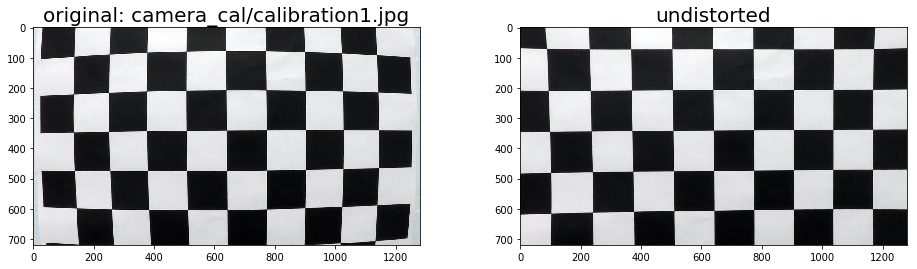

In [120]:
calibration_file = FOLDER_CAMERA_CAL + CALIBRATION__JPG
calibration_file_undistorted = cv2.undistort(cv2.imread(calibration_file), cali_mtx, cali_dist, None, cali_mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.imshow(cv2.imread(calibration_file))
ax1.set_title('original: ' + calibration_file, fontsize=20)
ax2.imshow(calibration_file_undistorted)
ax2.set_title('undistorted', fontsize=20)


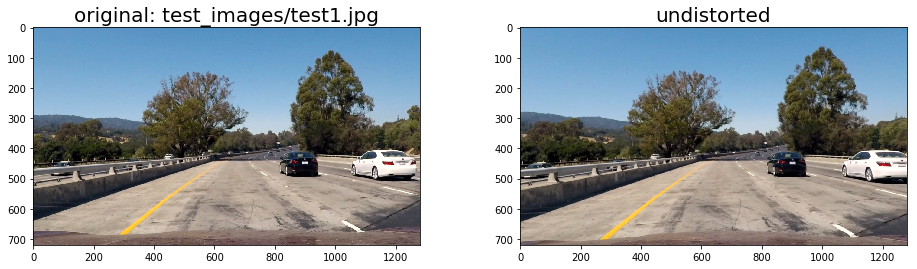

In [121]:
transformation_file = FOLDER_TEST_INPUT + TRANSFORMATION__JPG
transformation_image = cv2.imread(transformation_file)
transformation_image = cv2.cvtColor(transformation_image, cv2.COLOR_BGR2RGB)
undistorted_image = cv2.undistort(transformation_image, cali_mtx, cali_dist, None, cali_mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.imshow(transformation_image)
ax1.set_title('original: ' + transformation_file, fontsize=20)
ax2.imshow(undistorted_image)
ax2.set_title('undistorted', fontsize=20)


In [122]:


# from Udacity
def s_channel_and_gradient_threshold(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=SOBEL_KERNEL)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 90
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary


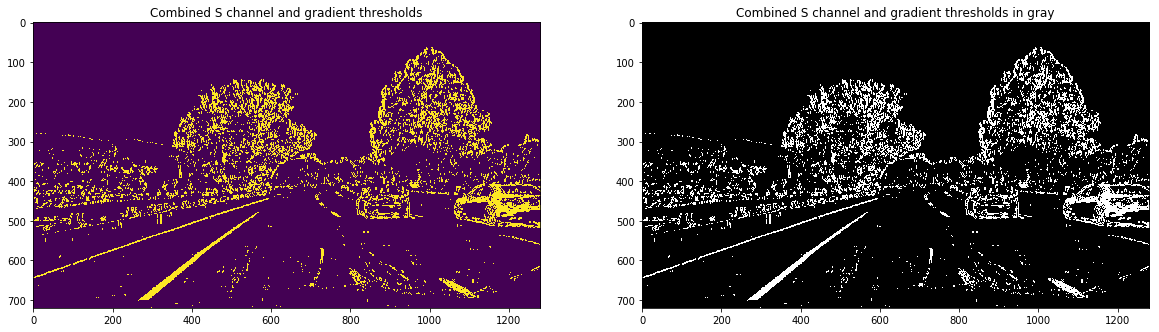

In [123]:
combined_binary = s_channel_and_gradient_threshold(undistorted_image)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Combined S channel and gradient thresholds')
ax1.imshow(combined_binary)

ax2.set_title('Combined S channel and gradient thresholds in gray')
ax2.imshow(combined_binary, cmap='gray')

In [124]:
# from Udacity
def unwarp(img, src, dst):
    h, w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

In [125]:
offset = 450
h, w = combined_binary.shape[:2]
# define source and destination points for transform
src = np.float32([(575, 464),
                  (707, 464),
                  (258, 682),
                  (1049, 682)])
dst = np.float32([(offset, 0),
                  (w - offset, 0),
                  (offset, h),
                  (w - offset, h)])

warped_binary, M, Minv = unwarp(combined_binary, src, dst)

offset = 150
vertices = np.array([[(offset, h), (w / 2, 400), (w / 2, 400), (w - offset, h)]], dtype=np.int32)


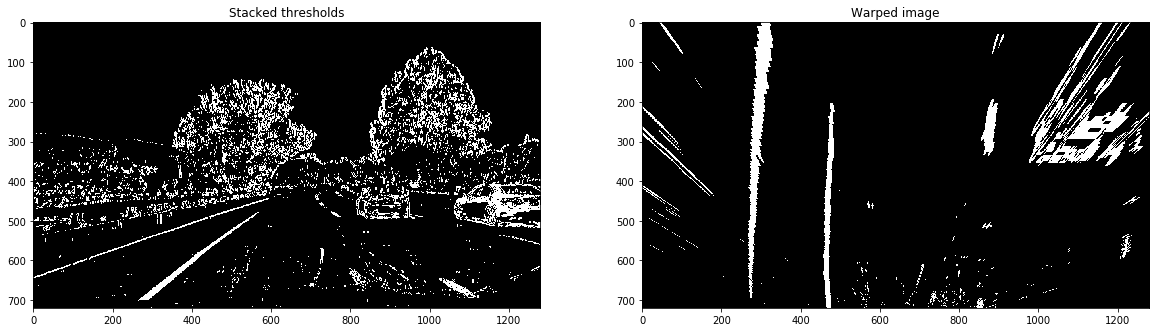

In [126]:
# Plotting warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Stacked thresholds')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Warped image')
ax2.imshow(warped_binary, cmap='gray')


In [127]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image


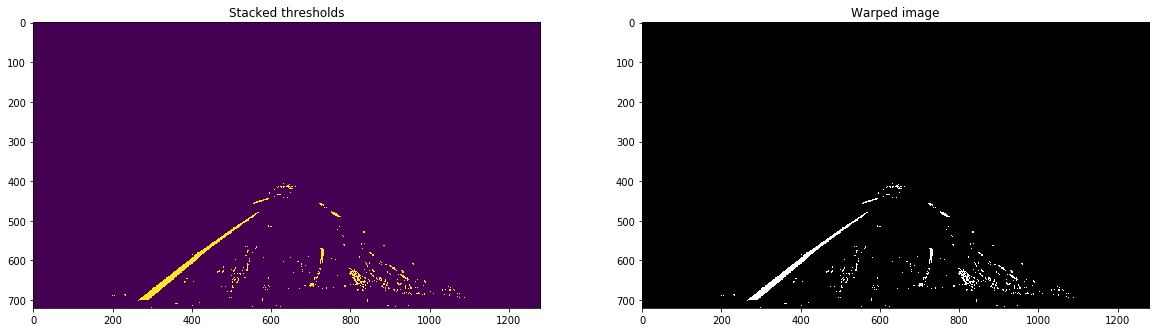

In [128]:
region_warped_binary = region_of_interest(combined_binary, vertices)

# Plotting image with region of interest
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Stacked thresholds')
ax1.imshow(region_warped_binary)

ax2.set_title('Warped image')
ax2.imshow(region_warped_binary, cmap='gray')


In [129]:

def process_pipeline(img):
    
    undist_image = cv2.undistort(img, cali_mtx, cali_dist, None, cali_mtx)

    c_binary = s_channel_and_gradient_threshold(undist_image)

    image_region_of_interest = region_of_interest(c_binary, vertices)

    warped_bin, M, Minv = unwarp(image_region_of_interest, src, dst)
    
    #return warped_binary, M, Minv
    return warped_bin


done


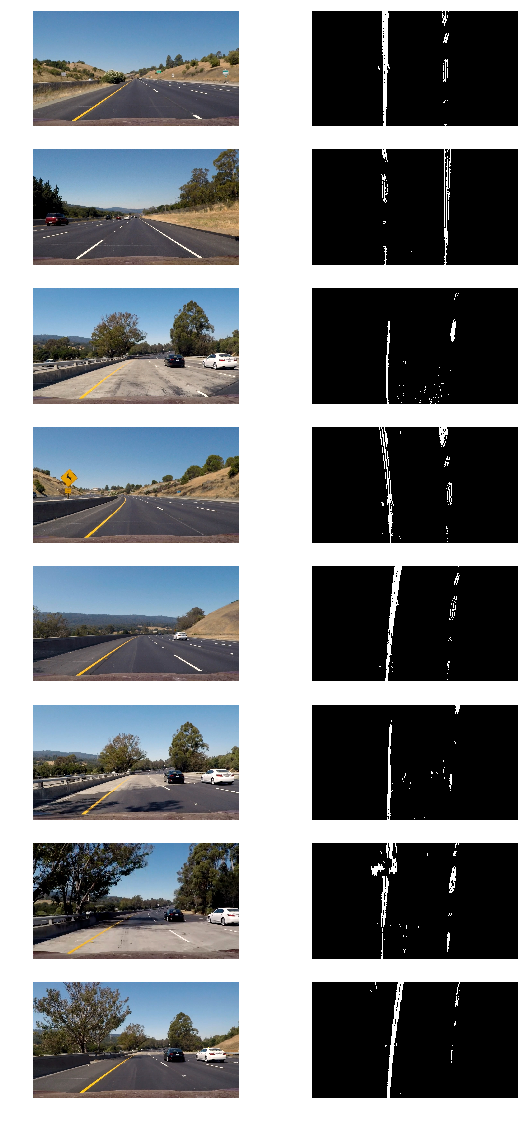

In [130]:


# Make a list of example images
images = glob.glob(FOLDER_TEST_INPUT + '*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images), 2, figsize=(10, 20))
fig.subplots_adjust(hspace=.2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    warped_binary = process_pipeline(img)

    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(warped_binary, cmap='gray')
    axs[i].axis('off')
    i += 1

print('done')


In [131]:

def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:, :]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


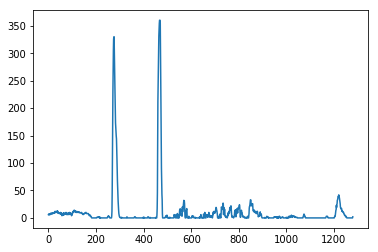

In [132]:
warped_binary, M, Minv = unwarp(combined_binary, src, dst)

# Create histogram of image binary activations
histogram = hist(warped_binary)

# Visualize the resulting histogram
plt.plot(histogram)


In [133]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 25

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


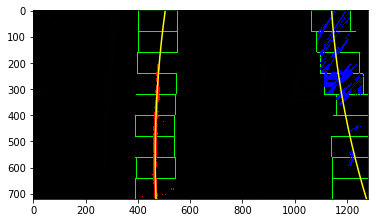

In [134]:
sliding_windows_image, left_fit_last, right_fit_last = fit_polynomial(warped_binary)

plt.imshow(sliding_windows_image)

In [135]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    measure_curvature_pixels(ploty, left_fitx, right_fitx)

    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped, left_fit, right_fit):
    # Choose the width of the margin around the previous polynomial to search
    margin = 60

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fitx, right_fitx, ploty = fit_poly(warped_binary.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    return result, left_lane_inds, right_lane_inds, ploty


In [136]:

def measure_curvature_pixels(ploty, leftx, rightx):
    # Calculates the curvature of polynomial functions in pixels.

    # Define conversions in x and y from pixels space to meters
    width = dst[3][1] - dst[0][1]
    height = dst[1][0] - dst[0][0]
    
    # TODO: Check ft vs. meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    #ym_per_pix = 12.0 / width # meters per pixel in y dimension
    #xm_per_pix = 10.0 / height # meters per pixel in x dimension
    print("height: ", height)
    print("width: ", width)
    print("ym_per_pix: ", ym_per_pix)
    print("xm_per_pix: ", xm_per_pix)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty) * ym_per_pix
    print("y_eval: ", y_eval)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)

    # TODO: add real world distance calculation
    # calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_position = transformation_image.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*h**2 + left_fit_cr[1]*h + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*h**2 + right_fit_cr[1]*h + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) / 2
    distance_from_center = (car_position - lane_center_position) * xm_per_pix

    return left_curverad, right_curverad, distance_from_center


In [137]:


# Calculate the radius of curvature in pixels for both lane lines
#left_curverad, right_curverad = measure_curvature_pixels(result, left_lane_inds, right_lane_inds)
#rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

#print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
#print('Distance from lane center for example:', d_center, 'm')


In [138]:
next_img = cv2.imread(FOLDER_TEST_INPUT + TRANSFORMATION2__JPG)
next_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
# Fit new polynomials

result, left_lane_inds, right_lane_inds, ploty = search_around_poly(process_pipeline(next_img), left_fit_last, right_fit_last)

# View your output
plt.imshow(result)


TypeError: expected non-empty vector for x

In [139]:

# TODO: from Udacity project lines on original image
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h, w = binary_img.shape[:2]
    print("H: ", h)
    print("W: ", w)
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    
    left_curverad, right_curverad, distance_from_center = measure_curvature_pixels(ploty, left_fitx, right_fitx)
    print("Left_rad: %f Right_rad: %f Distance: %f" % (left_curverad, right_curverad, distance_from_center))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result, left_curverad, right_curverad, distance_from_center

H:  720
W:  1280
height:  380.0
width:  720.0
ym_per_pix:  0.03048
xm_per_pix:  0.009788359788359789
y_eval:  21.91512
Left_rad: 383.985233 Right_rad: 296.451004 Distance: -1.379921


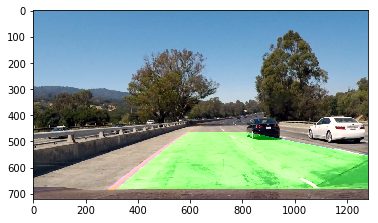

In [140]:
final_img, left_curverad, right_curverad, distance_from_center = draw_lane(transformation_image, warped_binary, left_fit_last, right_fit_last, Minv)
plt.imshow(final_img)


In [141]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_ITALIC
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40, 70), font, 1.5, (200, 255, 155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40, 120), font, 1.5, (200, 255, 155), 2, cv2.LINE_AA)
    return new_img


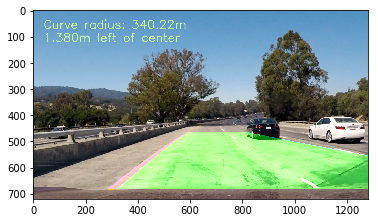

In [142]:
final_img_with_meta = draw_data(final_img, (left_curverad + right_curverad)/2, distance_from_center)
plt.imshow(final_img_with_meta)